In [ ]:
     # nếu đang dùng Colab thì có thể bỏ dòng này
!pip install   "accelerate" \
               "bitsandbytes" \
               "peft" \
               "trl" \
               "datasets"
!pip install --upgrade transformers


In [ ]:
from datasets import load_dataset
from datasets import Dataset
ds = load_dataset("vilm/OpenOrca-Viet",split="train[:10000]")
ds = ds.train_test_split(test_size=0.01)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 9900
    })
    test: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 100
    })
})

In [ ]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from trl import SFTTrainer
import torch
# =========================
# 0. DỌN CUDA
# =========================
# =========================
# 1. LOAD MODEL + TOKENIZER 4BIT
# =========================
model_name = "HuggingFaceH4/zephyr-7b-beta"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "right"
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_eos_token = True

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    low_cpu_mem_usage=True,
    device_map="auto",
)

# =========================
# 2. CHUẨN BỊ MODEL CHO KBIT + LORA
# =========================
model = prepare_model_for_kbit_training(model)
model.config.use_cache = False
model.gradient_checkpointing_enable()

peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
)

model_lora = get_peft_model(model, peft_config)

# =========================
# 3. HÀM IN SỐ PARAM TRAINABLE (OPTIONAL)
# =========================
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

print_trainable_parameters(model_lora)

# =========================
# 4. FORMAT TEXT + GIỚI HẠN max_length
# =========================
def text_formatting(data):
    messages = [
        {"role": "system", "content": data["instruction"]},
        {"role": "user", "content": data["input"]},
        {"role": "assistant", "content": data["output"]},
    ]
    data["chat_format"] = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=False
    )
    return data

ds["train"] = ds["train"].map(text_formatting)
ds["test"] = ds["test"].map(text_formatting)

MAX_LEN = 256  # nếu vẫn OOM thì giảm xuống 192 hoặc 128

def preprocess(example):
    text = example["chat_format"]
    tokens = tokenizer(
        text,
        max_length=MAX_LEN,
        truncation=True,
        padding="max_length",
    )
    return tokens

# ...
ds_train = ds["train"].map(preprocess, batched=False)
# uncomment this line
ds_test = ds["test"].map(preprocess, batched=False)
# nếu muốn eval sau này thì:
# ds_test = ds["test"].map(preprocess, batched=False)

# =========================
# 5. TRAINING ARGUMENTS – CẤU HÌNH TIẾT KIỆM VRAM
# =========================
training_arguments = TrainingArguments(
    per_device_train_batch_size=16,
    gradient_accumulation_steps=3,
    num_train_epochs=1,
    warmup_steps=100,
    max_steps=207,
    save_total_limit=2,
    learning_rate=2e-4,
    fp16=True,              # GPU bạn hỗ trợ bf16 thì có thể dùng bf16=True, fp16=False
    output_dir="outputs",
    logging_steps=20,
    eval_strategy="steps",     # tắt eval trong training cho nhẹ
    load_best_model_at_end=False,
    report_to="none",
)

# =========================
# 6. SFTTRAINER
# =========================
# =========================
# 6. SFTTRAINER
# =========================
trainer = SFTTrainer(
    model=model_lora,
    args=training_arguments,
    train_dataset=ds_train,
    eval_dataset=ds_test, # <a-- ADD THIS
    peft_config=peft_config
)



trainer.evaluate()
trainer.train()


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

trainable params: 20971520 || all params: 3773042688 || trainable%: 0.5558251452256031


Map:   0%|          | 0/9900 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/9900 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/bnb.py:397: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:282: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Truncating train dataset:   0%|          | 0/9900 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


Step,Training Loss,Validation Loss,Model Preparation Time,Entropy,Num Tokens,Mean Token Accuracy
20,1.666300,1.431859,0.005400,1.430070,327680.000000,0.670098
40,1.330800,1.229678,0.005400,1.227881,655360.000000,0.705694
60,1.216300,1.140431,0.005400,1.150006,983040.000000,0.725038
80,1.155000,1.096132,0.005400,1.132695,1310720.000000,0.732730
100,1.120600,1.065542,0.005400,1.100007,1638400.000000,0.737934
120,1.082400,1.034309,0.005400,1.039371,1966080.000000,0.743024
140,1.064700,1.017147,0.005400,1.034599,2293760.000000,0.745965
160,1.016900,1.005320,0.005400,0.965045,2616320.000000,0.749811
180,0.964200,0.996465,0.005400,0.964757,2944000.000000,0.751018
200,0.954400,0.989593,0.005400,0.971553,3271680.000000,0.752677


TrainOutput(global_step=200, training_loss=1.157157163619995, metrics={'train_runtime': 12095.379, 'train_samples_per_second': 1.058, 'train_steps_per_second': 0.017, 'total_flos': 1.3999449915260928e+17, 'train_loss': 1.157157163619995, 'epoch': 1.2907915993537964})

In [ ]:
trainer.evaluate()

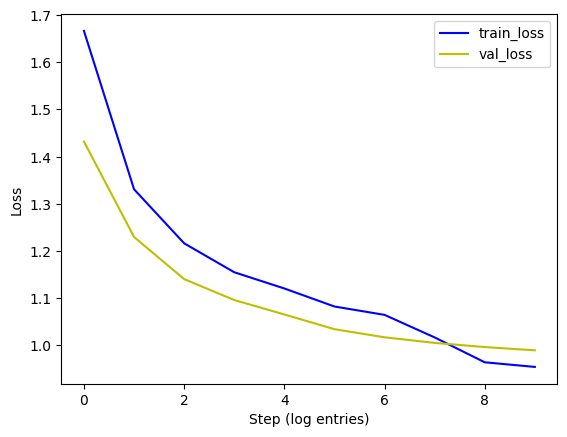

In [ ]:
from matplotlib import pyplot as plt

trainingEpoch_loss_adam = []
validationEpoch_loss_adam = []

for record in trainer.state.log_history:
    # record có thể là log train, log eval, hoặc log khác (learning_rate, epoch...)
    if "loss" in record and "eval_loss" not in record:
        # log loss trong quá trình train
        trainingEpoch_loss_adam.append(record["loss"])
    if "eval_loss" in record:
        validationEpoch_loss_adam.append(record["eval_loss"])

plt.plot(trainingEpoch_loss_adam, label="train_loss",color='b')
plt.plot(validationEpoch_loss_adam, label="val_loss",color='y')
plt.legend()
plt.xlabel("Step (log entries)")
plt.ylabel("Loss")
plt.show()


In [ ]:
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
import torch
from transformers import TextStreamer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_lora.to(device)
model_lora.eval()

messages = [
    {
        "role": "system",
        "content": "Bạn là một trợ lý AI giúp mọi người tìm kiếm thông tin.",
    },
    {"role": "user", "content": "Ai là người đầu tiên lên mặt trăng?"},
]
prompt = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,  # Zephyr sẽ thêm <|assistant|> ở cuối
)
print(repr(prompt))



'<|system|>\nBạn là một trợ lý AI giúp mọi người tìm kiếm thông tin.</s>\n<|user|>\nAi là người đầu tiên lên mặt trăng?</s>\n<|assistant|>\n'


In [ ]:
from huggingface_hub import login

# Thay 'YOUR_TOKEN_HERE' bằng token bạn copy
login(token="REMOVED_HF_TOKEN")


In [ ]:
model_name = "vietzephyr-7b-lora-8bit"
HUGGING_FACE_USER_NAME="duylamkhoaluan"
model_lora.push_to_hub(f"{HUGGING_FACE_USER_NAME}/{model_name}", use_auth_token=True)
tokenizer.push_to_hub(f"{HUGGING_FACE_USER_NAME}/{model_name}", use_auth_token=True)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...adapter_model.safetensors:   1%|          |  556kB / 83.9MB            

README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...pemuinvsz/tokenizer.model: 100%|##########|  493kB /  493kB            

CommitInfo(commit_url='https://huggingface.co/duylamkhoaluan/vietzephyr-7b-lora-8bit/commit/d7c60a0521923e3157e59ca854b712e19450c628', commit_message='Upload tokenizer', commit_description='', oid='d7c60a0521923e3157e59ca854b712e19450c628', pr_url=None, repo_url=RepoUrl('https://huggingface.co/duylamkhoaluan/vietzephyr-7b-lora-8bit', endpoint='https://huggingface.co', repo_type='model', repo_id='duylamkhoaluan/vietzephyr-7b-lora-8bit'), pr_revision=None, pr_num=None)

In [ ]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer
model_path = "duylamkhoaluan/vietzephyr-7b-lora-8bit"
config = PeftConfig.from_pretrained(model_path)
model_2 = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    return_dict=True,
    load_in_8bit=True,
    device_map='auto'
)
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

# Load the Lora model
qa_model = PeftModel.from_pretrained(model_2, model_path)

adapter_config.json: 0.00B [00:00, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/83.9M [00:00<?, ?B/s]

In [ ]:
from transformers import TextStreamer
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
qa_model.to(device)
qa_model.eval()

question = "Ai là người đầu tiên lên mặt trăng?"

messages = [
    {"role": "system", "content": "Bạn là một trợ lý AI giúp mọi người tìm kiếm thông tin."},
    {"role": "user", "content": question},
]

# Tạo prompt
prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

# Tokenize + chuyển device
inputs = tokenizer(prompt, return_tensors="pt", padding=False)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Streamer (nếu muốn stream ra màn hình)
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

# Generate
with torch.no_grad():
    with torch.autocast(device_type=device.type):
        output_tokens = qa_model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            streamer=streamer,
            max_new_tokens=100
        )

# Decode **chỉ phần trả lời**
full_text = tokenizer.decode(output_tokens[0], skip_special_tokens=False)

# Lấy phần sau token <|assistant|>
assistant_token = "<|assistant|>"
if assistant_token in full_text:
    answer = full_text.split(assistant_token, 1)[1].strip()
else:
    answer = full_text  # fallback nếu không tìm thấy

print("=== CÂU HỎI ===")
print(question)
print("\n=== CÂU TRẢ LỜI ===")
print(answer)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Người đầu tiên lên mặt trăng là Neil Armstrong, một tay sản của Hoa Kỳ, người đã đi bộ trên mặt trăng vào ngày 21 tháng 7 năm 1969.
=== CÂU HỎI ===
Ai là người đầu tiên lên mặt trăng?

=== CÂU TRẢ LỜI ===
Người đầu tiên lên mặt trăng là Neil Armstrong, một tay sản của Hoa Kỳ, người đã đi bộ trên mặt trăng vào ngày 21 tháng 7 năm 1969.</s>
